In [1]:
# ===============================================
# Local Projection Analysis – Vietnam
# (Logs; Age65 monthly interpolation; AI smoothed with 3M MA)
# ===============================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.close('all')

# --------------------------
# 0. Helpers to build log levels
# --------------------------
def build_index_from_mom(mom_pct: pd.Series, base=100.0) -> pd.Series:
    mom = mom_pct.astype(float) / 100.0
    idx = mom.index
    first_valid = mom.first_valid_index()
    out = pd.Series(index=idx, dtype=float)
    if first_valid is None:
        return out
    out.loc[first_valid] = base
    for t in range(idx.get_loc(first_valid) + 1, len(idx)):
        prev = out.iloc[t-1]
        g = mom.iloc[t]
        out.iloc[t] = prev * (1.0 + (0.0 if np.isnan(g) else g))
    return out

def build_index_from_yoy(yoy_pct: pd.Series, lam=1e-2, base=100.0) -> pd.Series:
    yoy = yoy_pct.astype(float) / 100.0
    idx = yoy.index
    T = len(idx)
    if T < 13 or yoy.notna().sum() < 13:
        return pd.Series(index=idx, dtype=float)

    rows, s_list = [], []
    for t in range(12, T):
        if np.isfinite(yoy.iloc[t]):
            row = np.zeros(T)
            row[t-11:t+1] = 1.0
            rows.append(row)
            s_list.append(np.log(1.0 + yoy.iloc[t]))
    if not rows:
        return pd.Series(index=idx, dtype=float)

    A = np.vstack(rows)
    s = np.array(s_list, dtype=float)
    ATA = A.T @ A + lam * np.eye(T)
    ATS = A.T @ s
    m = np.linalg.solve(ATA, ATS)                # monthly log growth
    l = np.cumsum(np.where(np.isfinite(m), m, 0.0))
    l0 = l[np.isfinite(l)].min()
    level = base * np.exp(l - l0)
    return pd.Series(level, index=idx, dtype=float)

def to_log_levels(df: pd.DataFrame,
                  level_col: str = None,
                  mom_col: str = None,
                  yoy_col: str = None) -> pd.Series:
    if level_col and level_col in df.columns and df[level_col].notna().any():
        return np.log(df[level_col].astype(float))
    if mom_col and mom_col in df.columns and df[mom_col].notna().any():
        idx = build_index_from_mom(df[mom_col])
        return np.log(idx)
    if yoy_col and yoy_col in df.columns and df[yoy_col].notna().any():
        idx = build_index_from_yoy(df[yoy_col])
        return np.log(idx)
    return pd.Series(index=df.index, dtype=float)

# --------------------------
# 1. Load dataset
# --------------------------
data = pd.read_excel("vn_analysis_panel_full_2013_2024.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date").set_index("Date")

# --------------------------
# 2. Construct IIP and CPI in log levels
# --------------------------
data["log_IIP"] = to_log_levels(
    data, level_col="IIP_index", mom_col="IIP_mom_pct", yoy_col="IIP_yoy_pct"
)
data["log_CPI"] = to_log_levels(
    data, level_col="CPI_index", mom_col="CPI_mom_pct", yoy_col="CPI_yoy_pct"
)

# --------------------------
# 3. Credit control: auto-detect a generic 'Credit' (level or % y/y)
# --------------------------
def _is_pct_series(s: pd.Series) -> bool:
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() < 24:
        return False
    q = s.quantile([0.05, 0.5, 0.95])
    return (q.loc[0.05] > -100) and (q.loc[0.95] < 150) and (abs(q.loc[0.5]) < 50)

CREDIT_VAR = None

if "Credit" in data.columns and data["Credit"].notna().any():
    credit_series = pd.to_numeric(data["Credit"], errors="coerce")
    if _is_pct_series(credit_series):
        data["Credit_yoy_pct"] = credit_series.astype(float)
        CREDIT_VAR = "Credit_yoy_pct"
    else:
        data["log_Credit"] = np.log(credit_series.astype(float))
        data["Credit_logchg"] = 100 * (data["log_Credit"] - data["log_Credit"].shift(1))  # ≈ % m/m
        CREDIT_VAR = "Credit_logchg"

if CREDIT_VAR is None and "Credit_outstanding" in data.columns and data["Credit_outstanding"].notna().any():
    data["log_Credit"] = np.log(pd.to_numeric(data["Credit_outstanding"], errors="coerce").astype(float))
    data["Credit_logchg"] = 100 * (data["log_Credit"] - data["log_Credit"].shift(1))
    CREDIT_VAR = "Credit_logchg"

if CREDIT_VAR is None and "Credit_yoy_pct" in data.columns and data["Credit_yoy_pct"].notna().any():
    CREDIT_VAR = "Credit_yoy_pct"

if CREDIT_VAR is None:
    data["Credit_placeholder"] = np.nan
    CREDIT_VAR = "Credit_placeholder"

print(f"Credit control used: {CREDIT_VAR}")

# --------------------------
# 4. Monetary policy shocks (residuals of ON rate on controls)
#    Do not include contemporaneous log_IIP/log_CPI here.
# --------------------------
y_rate = data["avg_VNIBOR_ON"]
controls_full = [
    CREDIT_VAR,
    "avg_VND_USD_rate", "NEER", "REER", "VN10Y",
    "FEDFUNDS", "WuXia_shadow_rate", "US10Y", "VIX", "DXY",
    "Brent_oil_price", "Global_food_price"
]
X_full = sm.add_constant(data[controls_full])
model_full = sm.OLS(y_rate, X_full, missing="drop").fit()
data["mp_shock"] = model_full.resid  # percentage points

# --------------------------
# 5. AI adoption index (PCA) with 3-month smoothing used in interactions
# --------------------------
# 5.1 Google Trends (monthly)
df_trends = pd.read_csv("google_trends_combined_2013_2024.csv", encoding="latin1")
df_trends["Date"] = pd.to_datetime(df_trends["Date"])
df_trends = df_trends.sort_values("Date").set_index("Date")

trends_keywords = df_trends.drop(columns=[] if "Date" not in df_trends.columns else ["Date"], errors="ignore")
trends_scaled = StandardScaler().fit_transform(trends_keywords.fillna(method="ffill").fillna(method="bfill"))
pca_trends = PCA(n_components=1)
AI_trends_PC1 = pca_trends.fit_transform(trends_scaled).flatten()
df_trends["AI_trends_PC1"] = AI_trends_PC1

# 5.2 Publications & Investment (annual → monthly alignment)
df_pub_inv = pd.read_excel("Vietnam_AI_inv_pub.xlsx")
df_pub_inv["AI_publications_z_y"] = StandardScaler().fit_transform(
    np.log1p(df_pub_inv["AI_publications"]).values.reshape(-1,1)
)
df_pub_inv["AI_investment_z_y"] = StandardScaler().fit_transform(
    np.log1p(df_pub_inv["AI_investment"]).values.reshape(-1,1)
)

df_pub_inv_monthly = pd.DataFrame({
    "Date": pd.date_range(start=f"{int(df_pub_inv['Year'].min())}-01-01",
                          end=f"{int(df_pub_inv['Year'].max())}-12-01", freq="MS")
}).set_index("Date")
df_pub_inv_monthly["Year"] = df_pub_inv_monthly.index.year
df_pub_inv_monthly = df_pub_inv_monthly.merge(
    df_pub_inv[["Year","AI_publications_z_y","AI_investment_z_y"]],
    on="Year", how="left"
).set_index(df_pub_inv_monthly.index)

# 5.3 Merge all AI components to a monthly frame
df_ai = pd.DataFrame(index=df_trends.index)
df_ai["AI_trends_PC1"] = df_trends["AI_trends_PC1"]
df_ai = df_ai.merge(
    df_pub_inv_monthly[["AI_publications_z_y","AI_investment_z_y"]],
    left_index=True, right_index=True, how="left"
)

# 5.4 Standardize together and PCA to composite
X_ai = df_ai[["AI_trends_PC1","AI_publications_z_y","AI_investment_z_y"]].copy()
X_ai = X_ai.fillna(method="ffill").fillna(method="bfill")
X_ai_scaled = StandardScaler().fit_transform(X_ai)
AI_index_PCA = PCA(n_components=1).fit_transform(X_ai_scaled).flatten()
df_ai["AI_index_PCA"] = AI_index_PCA

# 5.5 3-month centered moving average
df_ai["AI_index_PCA_ma3"] = pd.Series(AI_index_PCA, index=df_ai.index).rolling(3, center=True).mean()

# --------------------------
# 6. Merge AI and Aging; interpolate Age65 monthly (cubic → linear fallback)
# --------------------------
df = data.merge(df_ai[["AI_index_PCA", "AI_index_PCA_ma3"]], left_index=True, right_index=True, how="left")

if "Age65" in df.columns:
    try:
        df["Age65"] = df["Age65"].interpolate(method="cubic")
    except Exception:
        df["Age65"] = df["Age65"].interpolate(method="linear")
    df["Age65"] = df["Age65"].ffill().bfill()

# --------------------------
# 7. Local Projections on log levels
#     LHS: log(Y_{t+h}) - log(Y_t)
#     HAC: Newey–West with maxlags = h (bandwidth = h)
# --------------------------
def local_projection_logs(df_in, dep_log_col, shock_var="mp_shock",
                          controls=None, horizons=[1,3,6], interactions=None):
    if controls is None:
        controls = [CREDIT_VAR]
    if interactions is None:
        interactions = []
    results = {}
    for h in horizons:
        temp = df_in.copy()
        lhs = temp[dep_log_col].shift(-h) - temp[dep_log_col]
        X_h = pd.DataFrame({"shock": temp[shock_var]})
        for inter in interactions:
            X_h[f"shock_x_{inter}"] = temp[shock_var] * temp[inter]
        X_h["lag_dep"] = temp[dep_log_col].shift(1)
        for c in controls:
            if c in temp.columns:
                X_h[c] = temp[c]
        X_h = sm.add_constant(X_h)
        model = sm.OLS(lhs, X_h, missing="drop").fit(
            cov_type="HAC", cov_kwds={"maxlags": h}
        )
        results[h] = model
    return results

# Run models
lp_output     = local_projection_logs(df, "log_IIP")
lp_infl       = local_projection_logs(df, "log_CPI")
lp_output_age = local_projection_logs(df, "log_IIP", interactions=["Age65"])
lp_infl_age   = local_projection_logs(df, "log_CPI", interactions=["Age65"])
lp_output_ai  = local_projection_logs(df, "log_IIP", interactions=["AI_index_PCA_ma3"])
lp_infl_ai    = local_projection_logs(df, "log_CPI", interactions=["AI_index_PCA_ma3"])

# --------------------------
# 8. Plot helpers (IRFs and marginal effects)
# --------------------------
def draw_irf_shaded(lp_results, title, ylabel="Cumulative log response (≈ %)",
                    pdf: PdfPages = None):
    horizons = sorted(lp_results.keys())
    irf = np.array([lp_results[h].params.get('shock', np.nan) for h in horizons])
    se  = np.array([lp_results[h].bse.get('shock',   np.nan) for h in horizons])
    lo, hi = irf - 1.96*se, irf + 1.96*se
    fig = plt.figure(figsize=(7,5))
    plt.plot(horizons, irf, marker='o', linewidth=2, label='IRF')
    plt.fill_between(horizons, lo, hi, alpha=0.2, label='95% CI')
    plt.axhline(0, color='black', linewidth=1)
    plt.title(title, fontsize=13)
    plt.xlabel("Horizon (months)")
    plt.ylabel(ylabel)
    plt.grid(alpha=0.4, linestyle='--')
    plt.legend()
    plt.tight_layout()
    if pdf is not None:
        pdf.savefig(fig)
        plt.close(fig)
    else:
        plt.show()

def plot_marginal_effect(model_at_h, varname_interaction, title, x_label,
                         df_for_grid: pd.DataFrame, pdf: PdfPages = None):
    params = model_at_h.params
    cov    = model_at_h.cov_params()
    beta_name  = 'shock'
    delta_name = f'shock_x_{varname_interaction}'
    beta  = params.get(beta_name, np.nan)
    delta = params.get(delta_name, np.nan)

    x_series = df_for_grid[varname_interaction].dropna()
    if len(x_series) == 0:
        # create a dummy plot to avoid breaking PDF sequence
        fig = plt.figure(figsize=(7,5))
        plt.text(0.5,0.5,f"No data for {varname_interaction}", ha='center')
        plt.axis('off')
        if pdf is not None:
            pdf.savefig(fig); plt.close(fig)
        else:
            plt.show()
        return

    x_grid = np.linspace(x_series.quantile(0.05), x_series.quantile(0.95), 100)
    var_beta  = cov.loc[beta_name, beta_name] if beta_name in cov.index and beta_name in cov.columns else np.nan
    var_delta = cov.loc[delta_name, delta_name] if delta_name in cov.index and delta_name in cov.columns else np.nan
    cov_bd    = cov.loc[beta_name, delta_name] if (beta_name in cov.index and delta_name in cov.columns) else 0.0

    me = beta + delta * x_grid
    se = np.sqrt(var_beta + (x_grid**2) * var_delta + 2 * x_grid * cov_bd)

    fig = plt.figure(figsize=(7,5))
    plt.plot(x_grid, me, label='Marginal effect')
    if np.all(np.isfinite(se)):
        plt.fill_between(x_grid, me - 1.96*se, me + 1.96*se, alpha=0.2, label='95% CI')
    plt.axhline(0, color='black', linewidth=1)
    plt.title(title, fontsize=13)
    plt.xlabel(x_label)
    plt.ylabel('Cumulative log response (≈ %)')
    plt.legend()
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    if pdf is not None:
        pdf.savefig(fig)
        plt.close(fig)
    else:
        plt.show()

# --------------------------
# 9. Create and export the 10 plots to a single PDF
# --------------------------
with PdfPages("LP_results_10plots.pdf") as pdf:
    # 6 IRFs
    draw_irf_shaded(lp_output,     "IRF of log(IIP) to Monetary Shock (Baseline)", pdf=pdf)
    draw_irf_shaded(lp_infl,       "IRF of log(CPI) to Monetary Shock (Baseline)", pdf=pdf)
    draw_irf_shaded(lp_output_age, "IRF of log(IIP) to Shock × Age65",            pdf=pdf)
    draw_irf_shaded(lp_infl_age,   "IRF of log(CPI) to Shock × Age65",            pdf=pdf)
    draw_irf_shaded(lp_output_ai,  "IRF of log(IIP) to Shock × AI index (3M MA)", pdf=pdf)
    draw_irf_shaded(lp_infl_ai,    "IRF of log(CPI) to Shock × AI index (3M MA)", pdf=pdf)

    # 4 marginal effects (h = 3)
    plot_marginal_effect(lp_output_age[3], 'Age65',
                         'ME: Shock → log(IIP) across Aging (h=3)',
                         'Age65 (share)', df_for_grid=df, pdf=pdf)
    plot_marginal_effect(lp_infl_age[3],   'Age65',
                         'ME: Shock → log(CPI) across Aging (h=3)',
                         'Age65 (share)', df_for_grid=df, pdf=pdf)
    plot_marginal_effect(lp_output_ai[3],  'AI_index_PCA_ma3',
                         'ME: Shock → log(IIP) across AI (h=3, 3M MA)',
                         'AI composite (3M MA, z)', df_for_grid=df, pdf=pdf)
    plot_marginal_effect(lp_infl_ai[3],    'AI_index_PCA_ma3',
                         'ME: Shock → log(CPI) across AI (h=3, 3M MA)',
                         'AI composite (3M MA, z)', df_for_grid=df, pdf=pdf)

print("Saved 10 charts to LP_results_10plots.pdf")



Credit control used: Credit_logchg


C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\3745753042.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trends_scaled = StandardScaler().fit_transform(trends_keywords.fillna(method="ffill").fillna(method="bfill"))
C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\3745753042.py:185: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_ai = X_ai.fillna(method="ffill").fillna(method="bfill")


Saved 10 charts to LP_results_10plots.pdf


Credit variable used: Credit_logchg
Correlation between standardized regression shocks and standardized MCI: 0.455


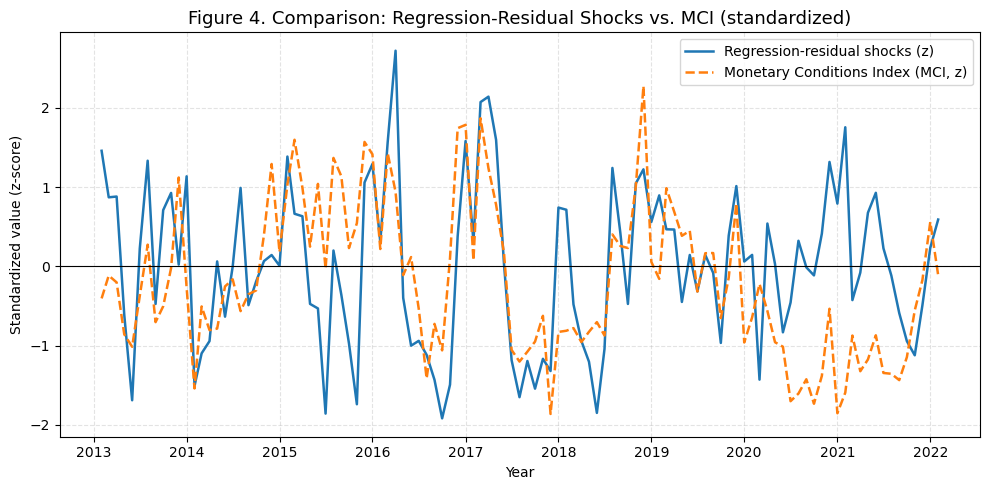

In [2]:
# =====================================
# Identification of Monetary Policy Shocks (Full Spec + MCI, log-spec consistent, with Credit detection)
# =====================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1) Load data
data = pd.read_excel("vn_analysis_panel_full_2013_2024.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date").set_index("Date")

# --------------------------
# 2) Detect credit variable automatically
# --------------------------
def _is_pct_series(s: pd.Series) -> bool:
    """Heuristic to detect percent growth-style series."""
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() < 24:
        return False
    q = s.quantile([0.05, 0.5, 0.95])
    return (q.loc[0.05] > -100) and (q.loc[0.95] < 150) and (abs(q.loc[0.5]) < 50)

CREDIT_VAR = None

if "Credit" in data.columns and data["Credit"].notna().any():
    credit_series = pd.to_numeric(data["Credit"], errors="coerce")
    if _is_pct_series(credit_series):
        data["Credit_yoy_pct"] = credit_series.astype(float)
        CREDIT_VAR = "Credit_yoy_pct"
    else:
        data["log_Credit"] = np.log(credit_series.astype(float))
        data["Credit_logchg"] = 100 * (data["log_Credit"] - data["log_Credit"].shift(1))
        CREDIT_VAR = "Credit_logchg"

if CREDIT_VAR is None and "Credit_outstanding" in data.columns and data["Credit_outstanding"].notna().any():
    data["log_Credit"] = np.log(pd.to_numeric(data["Credit_outstanding"], errors="coerce").astype(float))
    data["Credit_logchg"] = 100 * (data["log_Credit"] - data["log_Credit"].shift(1))
    CREDIT_VAR = "Credit_logchg"

if CREDIT_VAR is None and "Credit_yoy_pct" in data.columns and data["Credit_yoy_pct"].notna().any():
    CREDIT_VAR = "Credit_yoy_pct"

if CREDIT_VAR is None:
    data["Credit_placeholder"] = np.nan
    CREDIT_VAR = "Credit_placeholder"

print(f"Credit variable used: {CREDIT_VAR}")

# --------------------------
# 3) Regression-residual shocks (baseline)
# --------------------------
y = data["avg_VNIBOR_ON"]

controls_full = [
    CREDIT_VAR,
    "avg_VND_USD_rate", "NEER", "REER", "VN10Y",
    "FEDFUNDS", "WuXia_shadow_rate", "US10Y", "VIX", "DXY",
    "Brent_oil_price", "Global_food_price"
]
X_full = sm.add_constant(data[controls_full])
model_full = sm.OLS(y, X_full, missing="drop").fit()
data["mp_shock"] = model_full.resid  # percentage points of VNIBOR ON

# --------------------------
# 4) Monetary Conditions Index (MCI)
#    Components: policy rate r_t, credit, REER
# --------------------------
# Use the chosen credit variable (CREDIT_VAR)
mci_components = data[["avg_VNIBOR_ON", CREDIT_VAR, "REER"]].copy()
mci_components = mci_components.rename(columns={CREDIT_VAR: "Credit_component"})

# Standardize components (z-scores)
scaler = StandardScaler()
mci_z = pd.DataFrame(
    scaler.fit_transform(mci_components),
    columns=mci_components.columns,
    index=mci_components.index
)

# IMF-style weights: 0.5 rate, 0.3 credit, 0.2 REER (positive = tighter)
# Interpretation: higher rate, higher credit growth, and REER appreciation → tighter conditions
data["MCI_raw"] = (
    0.5 * mci_z["avg_VNIBOR_ON"] +
    0.3 * mci_z["Credit_component"] +
    0.2 * mci_z["REER"]
)

# Standardize MCI for comparison
data["MCI_z"] = (data["MCI_raw"] - data["MCI_raw"].mean()) / data["MCI_raw"].std()

# --------------------------
# 5) Comparison and visualization (Figure 4)
# --------------------------
df_compare = data[["mp_shock", "MCI_z"]].dropna().copy()
df_compare["mp_shock_z"] = (df_compare["mp_shock"] - df_compare["mp_shock"].mean()) / df_compare["mp_shock"].std()

corr = df_compare["mp_shock_z"].corr(df_compare["MCI_z"])
print(f"Correlation between standardized regression shocks and standardized MCI: {corr:.3f}")

plt.figure(figsize=(10,5))
plt.plot(df_compare.index, df_compare["mp_shock_z"], label="Regression-residual shocks (z)", linewidth=1.8)
plt.plot(df_compare.index, df_compare["MCI_z"],       label="Monetary Conditions Index (MCI, z)", linestyle="--", linewidth=1.8)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Figure 4. Comparison: Regression-Residual Shocks vs. MCI (standardized)", fontsize=13)
plt.xlabel("Year")
plt.ylabel("Standardized value (z-score)")
plt.legend()
plt.grid(alpha=0.35, linestyle="--")
plt.tight_layout()
plt.savefig("Figure4_Comparison_MCI_vs_Shocks.png", dpi=300)
plt.show()
